<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')

In [ ]:
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']

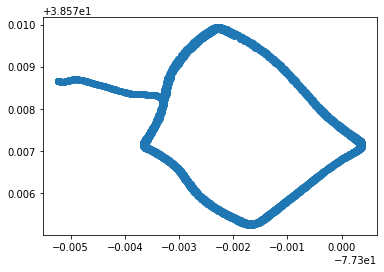

In [24]:
#Display map
plt.scatter(x=data['Longitude'], y=data['Latitude'])

In [77]:
#calculate the distance on Longitude/ Latitude plane assuming 2D plane

data['Lat diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Latitude']
data['Long diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Longitude']

data[['Lat diff5','Long diff5']].fillna(0, inplace = True)

data['Lat diff-5'] = data.groupby(['Lap Number']).transform(lambda x: x.shift(-5) -x )['Latitude']
data['Lon diff-5'] = data.groupby(['Lap Number']).transform(lambda x: x.shift(-5) -x )['Longitude']

<ipython-input-77-0f13344311e4>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  data['Lat diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Latitude']
<ipython-input-77-0f13344311e4>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  data['Long diff5'] = data.groupby(['Lap Number']).transform(lambda x: x.diff(5))['Longitude']


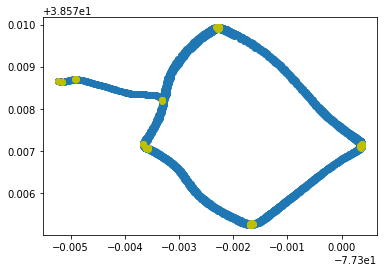

In [143]:
#flag corner rows

data['corner'] = 0
data.loc[((data['Lat diff-5'] > 0) & (data['Lat diff5'] < 0))| ((data['Lat diff-5'] < 0) & (data['Lat diff5'] > 0)) 
| ((data['Lon diff-5'] > 0) & (data['Long diff5'] < 0))
| ((data['Lon diff-5'] < 0) & (data['Long diff5'] >= 0)), 'corner'] = 1 


plt.scatter(x=data['Longitude'], y=data['Latitude'])
plt.scatter(x=data.loc[data['corner'] == 1, 'Longitude'], y=data.loc[data['corner'] == 1,'Latitude'], color = 'y')

In [ ]:
#check if we got all laps
data.loc[data['c']==1, 'Lap Number'].unique()

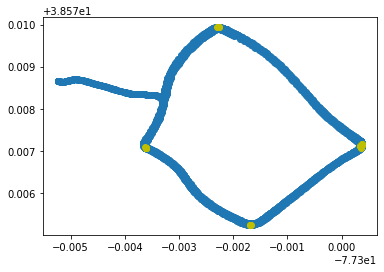

In [144]:
#Points on the left can be eliminated by setting Gy-value (absolute) to >11, but then we lose data from the first lap

plt.scatter(x=data['Longitude'], y=data['Latitude'])
plt.scatter(x=data.loc[(data['corner'] == 1) & (data['Gy clean'].abs() >11), 'Longitude'], y=data.loc[(data['corner'] == 1) 
& (data['Gy clean'].abs() >11),'Latitude'], color = 'y')